In [1]:
import os
import glob
import numpy as np
from matplotlib import pyplot as plt
from osgeo import gdal
import pandas as pd
from keras.utils import to_categorical
import tensorflow as tf
from sklearn.utils import class_weight
import random

In [2]:
train_images = []
image_names = glob.glob(r"C:\Document\University\2023_Spring_Junior\GEOG_491\Dataset\August_Complex\Deep_learning\256\training_image\images/*.tif")
image_names.sort()
for img_path in image_names:
      # print(img_path)
      tiff_image = gdal.Open(img_path, 0)
      band7 = tiff_image.GetRasterBand(7).ReadAsArray()
      band8 = tiff_image.GetRasterBand(8).ReadAsArray()
      band9 = tiff_image.GetRasterBand(9).ReadAsArray()

      X = np.stack((band9, band8, band7), axis=-1)
      train_images.append(X)

train_images = np.array(train_images)
print(np.mean(train_images))
# train_images = train_images / (2**16-1)
# train_images = train_images.astype(int)

# normalize
# low, high = np.percentile(X, (2, 98))
# train_images = (train_images-low)/(high-low)
X_train = train_images
print(X_train.shape)

train_masks = []
image_names = glob.glob(r"C:\Document\University\2023_Spring_Junior\GEOG_491\Dataset\August_Complex\Deep_learning\mask\ps\multi\truth_2\train\images/*.tif")
image_names.sort()
for img_path in image_names:
  #  print(img_path)
   tiff_image = gdal.Open(img_path, 0)
   band1 = tiff_image.GetRasterBand(1).ReadAsArray()
   train_masks.append(band1)

train_masks = np.array(train_masks)
y_train = train_masks
print(y_train.shape)

y_train_cat = to_categorical(train_masks, num_classes=4)
y_train_cat = y_train_cat.astype(int)
print(y_train_cat.shape)

C:\Users\wumin\anaconda3\envs\deep_learning\lib\site-packages\osgeo\gdal.py:287: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


1283.7584615587612
(690, 256, 256, 3)
(690, 256, 256)
(690, 256, 256, 4)


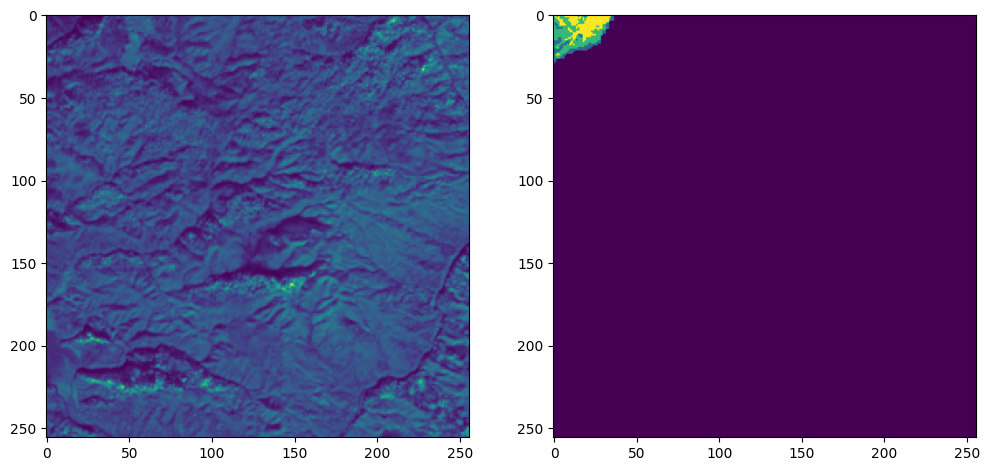

612


In [3]:
#Sanity check, view few images
import random
import numpy as np
image_number = random.randint(0, len(train_images)-1)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape((train_images[image_number, :, :, 2]), (256, 256, 1)))
plt.subplot(122)
plt.imshow(np.reshape(train_masks[image_number], (256, 256, 1)))
plt.show()
print(image_number)

In [4]:
test_images = []
image_names = glob.glob(r"C:\Document\University\2023_Spring_Junior\GEOG_491\Dataset\August_Complex\Deep_learning\256\testing_image\images/*.tif")
image_names.sort()
for img_path in image_names:
      # print(img_path)
      tiff_image = gdal.Open(img_path, 0)
      band7 = tiff_image.GetRasterBand(7).ReadAsArray()
      band8 = tiff_image.GetRasterBand(8).ReadAsArray()
      band9 = tiff_image.GetRasterBand(9).ReadAsArray()

      X = np.stack((band9, band8, band7), axis=-1)
      test_images.append(X)

test_images = np.array(test_images)
print(np.mean(test_images))
# normalize
# test_images = test_images / (2**16-1)
# test_images = test_images.astype(int)
# low, high = np.percentile(X, (2, 98))
# test_images = (test_images-low)/(high-low)
print(test_images.shape)

test_masks = []
image_names = glob.glob(r"C:\Document\University\2023_Spring_Junior\GEOG_491\Dataset\August_Complex\Deep_learning\mask\ps\multi\truth_2\test\images/*.tif")
image_names.sort()
for img_path in image_names:
  #  print(img_path)
   tiff_image = gdal.Open(img_path, 0)
   band1 = tiff_image.GetRasterBand(1).ReadAsArray()
   test_masks.append(band1)

test_masks = np.array(test_masks)
# test_masks = test_masks
# masks = train_masks.astype(int)
print(np.unique(test_masks))

y_test_cat = to_categorical(test_masks, num_classes=4)
y_test_cat = y_test_cat.astype(int)
print(y_test_cat.shape)
print(np.unique(y_test_cat))

1314.3571367617008
(36, 256, 256, 3)
[0 1 2 3]
(36, 256, 256, 4)
[0 1]


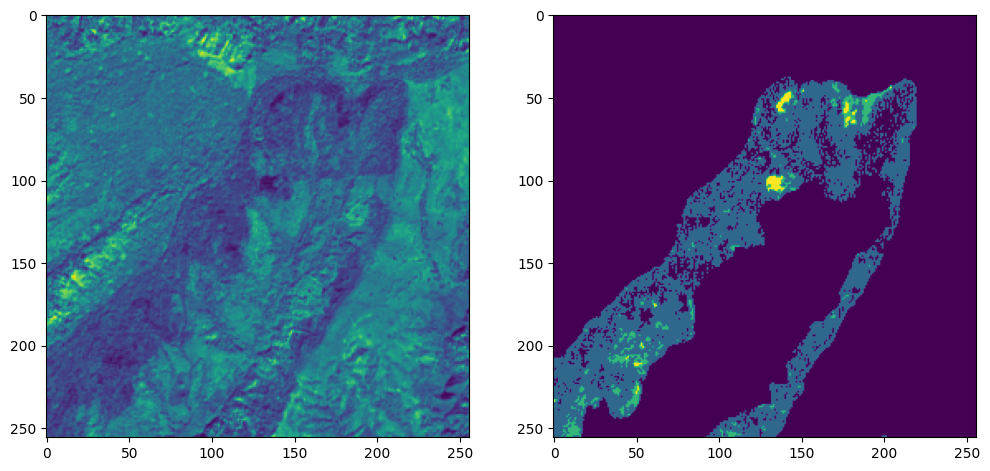

3


In [5]:
# #Sanity check, view few images
image_number = random.randint(0, len(test_images)-1)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape((test_images[image_number, :, :, 2]), (256, 256, 1)))
plt.subplot(122)
plt.imshow(np.reshape(test_masks[image_number], (256, 256, 1)))
plt.show()
print(image_number)

In [6]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Activation, multiply
# def attention_block(x, g):
#     theta_x = Conv2D(filters=8, kernel_size=(1, 1), strides=(1, 1), padding='same')(x)
#     phi_g = Conv2D(filters=8, kernel_size=(1, 1), strides=(1, 1), padding='same')(g)
#     f = Activation('relu')(theta_x + phi_g)
#     psi_f = Conv2D(filters=1, kernel_size=(1, 1), strides=(1, 1), padding='same')(f)
#     attention_weights = Activation('softmax')(psi_f)
#     attention_output = multiply([x, attention_weights])
#     return attention_output

# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, Add
# def residual_block(input_layer, filters):
#     conv1 = Conv2D(filters, kernel_size=(3, 3), activation='relu', padding='same')(input_layer)
#     conv2 = Conv2D(filters, kernel_size=(3, 3), activation='relu', padding='same')(conv1)
#     residual = Add()([conv2, input_layer])
#     return residual

import tensorflow as tf
from tensorflow.keras import models, layers, regularizers
from tensorflow.keras import backend as K

def conv_block(x, filter_size, size, dropout, batch_norm=False):

    conv = layers.Conv2D(size, (filter_size, filter_size), padding="same")(x)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation("relu")(conv)

    conv = layers.Conv2D(size, (filter_size, filter_size), padding="same")(conv)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation("relu")(conv)

    if dropout > 0:
        conv = layers.Dropout(dropout)(conv)

    return conv


def repeat_elem(tensor, rep):
    # lambda function to repeat Repeats the elements of a tensor along an axis
    #by a factor of rep.
    # If tensor has shape (None, 256,256,3), lambda will return a tensor of shape
    #(None, 256,256,6), if specified axis=3 and rep=2.

     return layers.Lambda(lambda x, repnum: K.repeat_elements(x, repnum, axis=3),
                          arguments={'repnum': rep})(tensor)

def gating_signal(input, out_size, batch_norm=False):
    """
    resize the down layer feature map into the same dimension as the up layer feature map
    using 1x1 conv
    :return: the gating feature map with the same dimension of the up layer feature map
    """
    x = layers.Conv2D(out_size, (1, 1), padding='same')(input)
    if batch_norm:
        x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    return x

def attention_block(x, gating, inter_shape):
    shape_x = K.int_shape(x)
    shape_g = K.int_shape(gating)

# Getting the x signal to the same shape as the gating signal
    theta_x = layers.Conv2D(inter_shape, (2, 2), strides=(2, 2), padding='same')(x)  # 16
    shape_theta_x = K.int_shape(theta_x)

# Getting the gating signal to the same number of filters as the inter_shape
    phi_g = layers.Conv2D(inter_shape, (1, 1), padding='same')(gating)
    upsample_g = layers.Conv2DTranspose(inter_shape, (3, 3),
                                 strides=(shape_theta_x[1] // shape_g[1], shape_theta_x[2] // shape_g[2]),
                                 padding='same')(phi_g)  # 16

    concat_xg = layers.add([upsample_g, theta_x])
    act_xg = layers.Activation('relu')(concat_xg)
    psi = layers.Conv2D(1, (1, 1), padding='same')(act_xg)
    sigmoid_xg = layers.Activation('sigmoid')(psi)
    shape_sigmoid = K.int_shape(sigmoid_xg)
    upsample_psi = layers.UpSampling2D(size=(shape_x[1] // shape_sigmoid[1], shape_x[2] // shape_sigmoid[2]))(sigmoid_xg)  # 32

    upsample_psi = repeat_elem(upsample_psi, shape_x[3])

    y = layers.multiply([upsample_psi, x])

    result = layers.Conv2D(shape_x[3], (1, 1), padding='same')(y)
    result_bn = layers.BatchNormalization()(result)
    return result_bn

def res_conv_block(x, filter_size, size, dropout, batch_norm=False):
    '''
    Residual convolutional layer.
    Two variants....
    Either put activation function before the addition with shortcut
    or after the addition (which would be as proposed in the original resNet).

    1. conv - BN - Activation - conv - BN - Activation
                                          - shortcut  - BN - shortcut+BN

    2. conv - BN - Activation - conv - BN
                                     - shortcut  - BN - shortcut+BN - Activation

    Check fig 4 in https://arxiv.org/ftp/arxiv/papers/1802/1802.06955.pdf
    '''

    conv = layers.Conv2D(size, (filter_size, filter_size), padding='same')(x)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation('relu')(conv)

    conv = layers.Conv2D(size, (filter_size, filter_size), padding='same')(conv)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    #conv = layers.Activation('relu')(conv)    #Activation before addition with shortcut
    if dropout > 0:
        conv = layers.Dropout(dropout)(conv)

    shortcut = layers.Conv2D(size, kernel_size=(1, 1), padding='same')(x)
    if batch_norm is True:
        shortcut = layers.BatchNormalization(axis=3)(shortcut)

    res_path = layers.add([shortcut, conv])
    res_path = layers.Activation('relu')(res_path)    #Activation after addition with shortcut (Original residual block)
    return res_path


In [7]:
def UNet(input_shape, NUM_CLASSES=4, dropout_rate=0.1, batch_norm=True):
    '''
    UNet,

    '''
    # network structure
    FILTER_NUM = 16 # number of filters for the first layer
    FILTER_SIZE = 3 # size of the convolutional filter
    UP_SAMP_SIZE = 2 # size of upsampling filters


    inputs = layers.Input(input_shape)

    # Downsampling layers
    # DownRes 1, convolution + pooling
    conv_128 = conv_block(inputs, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)
    pool_64 = layers.MaxPooling2D(pool_size=(2,2))(conv_128)
    # DownRes 2
    conv_64 = conv_block(pool_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    pool_32 = layers.MaxPooling2D(pool_size=(2,2))(conv_64)
    # DownRes 3
    conv_32 = conv_block(pool_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    pool_16 = layers.MaxPooling2D(pool_size=(2,2))(conv_32)
    # DownRes 4
    conv_16 = conv_block(pool_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    pool_8 = layers.MaxPooling2D(pool_size=(2,2))(conv_16)
    # DownRes 5, convolution only
    conv_8 = conv_block(pool_8, FILTER_SIZE, 16*FILTER_NUM, dropout_rate, batch_norm)

    # Upsampling layers

    up_16 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(conv_8)
    up_16 = layers.concatenate([up_16, conv_16], axis=3)
    up_conv_16 = conv_block(up_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 7

    up_32 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_16)
    up_32 = layers.concatenate([up_32, conv_32], axis=3)
    up_conv_32 = conv_block(up_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 8

    up_64 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_32)
    up_64 = layers.concatenate([up_64, conv_64], axis=3)
    up_conv_64 = conv_block(up_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 9

    up_128 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_64)
    up_128 = layers.concatenate([up_128, conv_128], axis=3)
    up_conv_128 = conv_block(up_128, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)

    # 1*1 convolutional layers

    conv_final = layers.Conv2D(NUM_CLASSES, kernel_size=(1,1))(up_conv_128)
    conv_final = layers.BatchNormalization(axis=3)(conv_final)
    conv_final = layers.Activation('softmax')(conv_final)

    # Model
    model = models.Model(inputs, conv_final, name="UNet")
    print(model.summary())
    return model

In [8]:
import tensorflow as tf
from keras import backend as K

def categorical_mean_iou_loss(y_true, y_pred):
    y_true = tf.cast(y_true, y_pred.dtype)  # Convert y_true to the same data type as y_pred

    # Calculate intersection and union
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1, 2])
    union = K.sum(y_true, axis=[1, 2]) + K.sum(y_pred, axis=[1, 2]) - intersection

    # Calculate mean IoU loss
    iou = (intersection + K.epsilon()) / (union + K.epsilon())
    mean_iou_loss = 1 - K.mean(iou)

    return mean_iou_loss

In [9]:
class MyMeanIOU(tf.keras.metrics.MeanIoU):
    def update_state(self, y_true, y_pred, sample_weight=None):
        return super().update_state(tf.argmax(y_true, axis=-1), tf.argmax(y_pred, axis=-1), sample_weight)

In [10]:
from keras.callbacks import Callback

# Custom callback to stop training at a specific validation accuracy
class StopAtValidationAccuracy(Callback):
    def __init__(self, target_accuracy):
        super(StopAtValidationAccuracy, self).__init__()
        self.target_accuracy = target_accuracy

    def on_epoch_end(self, epoch, logs=None):
        if logs['val_my_mean_iou'] >= self.target_accuracy:
            self.model.stop_training = True
            print(f"\nReached target validation accuracy ({self.target_accuracy}), stopping training!")

# Define the custom callback with the desired target validation accuracy
target_accuracy = 0.58
stop_at_accuracy = StopAtValidationAccuracy(target_accuracy)

In [11]:
# training
opt = tf.keras.optimizers.Adam(learning_rate=0.000001)
# def get_model():
#     return multi_unet_model(n_classes=4, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=3)
# def get_model():
#     return Attention_UNet((256, 256, 3))
def get_model():
    return UNet((256, 256, 3))
# def get_model():
#     return Attention_ResUNet_stacked((256, 256, 9))
model = get_model()
model.compile(optimizer = 'adam', loss=categorical_mean_iou_loss, metrics = [MyMeanIOU(4)])
# tf.keras.losses.CategoricalCrossentropy()
# categorical_focal_loss(gamma=2.0, alpha=0.25)

Model: "UNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 16  64         ['conv2d[0][0]']                 
 alization)                     )                                                              

In [12]:
# fitting model
import time
start_time = time.time()
history = model.fit(train_images, y_train_cat,
                    batch_size = 8,
                    verbose=1,
                    epochs=50,
                    validation_data=(test_images, y_test_cat),
                    callbacks=[stop_at_accuracy],
                    shuffle=True)

end_time = time.time()
elapsed_time = end_time - start_time
print("Training time: {:.2f} seconds".format(elapsed_time))

Epoch 1/50
87/87 [==============================] - 14s 96ms/step - loss: 0.8504 - my_mean_iou: 0.3819 - val_loss: 0.8111 - val_my_mean_iou: 0.2217
Epoch 2/50
87/87 [==============================] - 7s 86ms/step - loss: 0.8303 - my_mean_iou: 0.4099 - val_loss: 0.8151 - val_my_mean_iou: 0.3120
Epoch 3/50
87/87 [==============================] - 7s 86ms/step - loss: 0.8142 - my_mean_iou: 0.4449 - val_loss: 0.7926 - val_my_mean_iou: 0.4194
Epoch 4/50
87/87 [==============================] - 8s 87ms/step - loss: 0.8036 - my_mean_iou: 0.4579 - val_loss: 0.7580 - val_my_mean_iou: 0.4726
Epoch 5/50
87/87 [==============================] - 7s 86ms/step - loss: 0.7924 - my_mean_iou: 0.4750 - val_loss: 0.7793 - val_my_mean_iou: 0.4120
Epoch 6/50
87/87 [==============================] - 7s 86ms/step - loss: 0.7815 - my_mean_iou: 0.4806 - val_loss: 0.7432 - val_my_mean_iou: 0.4551
Epoch 7/50
87/87 [==============================] - 7s 86ms/step - loss: 0.7740 - my_mean_iou: 0.4864 - val_loss: 0.7

In [13]:
model.save(r"C:\Document\University\2023_Spring_Junior\GEOG_491\Dataset\August_Complex\Deep_learning\models_new\unet.h5")

In [15]:
from sklearn.metrics import classification_report
from sklearn import metrics
import tensorflow as tf
predicted = np.expand_dims(test_images, 0)
prediction = (model.predict(test_images))
print(prediction.shape)
predicted_img = np.argmax(prediction, axis=3)[:,:,:]
y_test_pred = test_masks
# print(y_test.shape)
print(predicted_img.shape)
cm = metrics.confusion_matrix(y_test_pred.reshape(-1), predicted_img.reshape(-1))
print(cm, "\n")
print(classification_report(y_test_pred.reshape(-1), predicted_img.reshape(-1), digits=4))

from keras.metrics import MeanIoU
IOU_keras = MeanIoU(num_classes=4)
IOU_keras.update_state(y_test_pred.reshape(-1), predicted_img.reshape(-1))
print("Mean IoU = ", IOU_keras.result().numpy())
values = np.array(IOU_keras.get_weights()).reshape(4, 4)
class1_IoU = values[0,0]/(values[0,0] + values[0,1] + values[0,2] + values[0,3] + values[1,0] + values[2,0] + values[3,0])
class2_IoU = values[1,1]/(values[1,1] + values[1,0] + values[1,2] + values[1,3] + values[0,1] + values[2,1] + values[3,1])
class3_IoU = values[2,2]/(values[2,2] + values[2,0] + values[2,1] + values[2,3] + values[0,2] + values[1,2] + values[3,2])
class4_IoU = values[3,3]/(values[3,3] + values[3,0] + values[3,1] + values[3,2] + values[0,3] + values[1,3] + values[2,3])
print("class1 IoU = ", class1_IoU)
print("class2 IoU = ", class2_IoU)
print("class3 IoU = ", class3_IoU)
print("class4 IoU = ", class4_IoU)

m = tf.keras.metrics.Accuracy()
m.update_state(y_test_pred.reshape(-1), predicted_img.reshape(-1))
print('\n', 'Accuracy = ', m.result().numpy())

from sklearn.metrics import cohen_kappa_score
kappa_score = cohen_kappa_score(y_test_pred.reshape(-1), predicted_img.reshape(-1))
print("Kappa:", kappa_score)

2/2 [==============================] - 1s 30ms/step
(36, 256, 256, 4)
(36, 256, 256)
[[1572576   63546    3482     638]
 [  29257  242808   66850   11877]
 [   5483   58429   98836   35112]
 [   2190    3022   38848  126342]] 

              precision    recall  f1-score   support

           0     0.9771    0.9587    0.9678   1640242
           1     0.6602    0.6922    0.6758    350792
           2     0.4751    0.4995    0.4870    197860
           3     0.7262    0.7414    0.7338    170402

    accuracy                         0.8649   2359296
   macro avg     0.7096    0.7230    0.7161   2359296
weighted avg     0.8697    0.8649    0.8672   2359296

Mean IoU =  0.5873338
class1 IoU =  0.9376355
class2 IoU =  0.51032704
class3 IoU =  0.3218994
class4 IoU =  0.5794734

 Accuracy =  0.8649029
Kappa: 0.7241901952541665


1/1 [==============================] - 0s 20ms/step


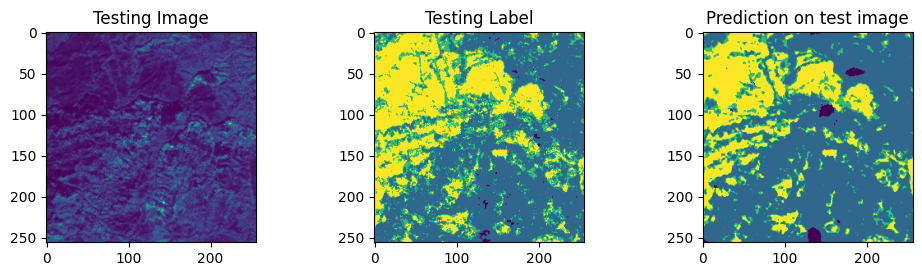

In [24]:
#Randomly check on train images
image_number = random.randint(0, len(train_images)-1)
predicted = np.expand_dims(train_images[image_number], 0)
prediction = (model.predict(predicted))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]
# print(prediction[0, 0, :, :])
# print(prediction[0, 1, 1, :])
# print(predicted_img)
plt.figure(figsize=(12, 6))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(np.reshape((train_images[image_number, :, :, 2]), (256, 256, 1)))
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(np.reshape(train_masks[image_number], (256, 256, 1)))
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(np.reshape((predicted_img), (256, 256, 1)))
plt.show()